# Palm Oil Price

Предсказание динамики цен пальмового масла с учетом сезонного фактора. Модель SARIMA

Вопросы? Дмитрий Ходыкин, skype: dmitriy\_hodikin

## Пространство имен

In [171]:
# pip install quandl ml_metrics matplotlib statsmodels sklearn psycopg2

In [213]:
# Импорты

import quandl            # Датасеты
import datetime          # Дата-время
from auth import auth    # Авторизационные данные
import numpy as np       # Матрицы и вычисления
import pandas as pd      # Таблицы и фильтры
import warnings          # Ворнинги
import psycopg2 as psql  # Postgres

# Визуализация данных
import matplotlib.pyplot as plt

# Статистические модели и машинное обучение
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.iolib.table import SimpleTable
import scipy.stats as scs
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
import ml_metrics as metrics #pip install ml_metrics
from itertools import product

## Загрузка данных

In [173]:
# Авторизяаиц в API сервиса данных
quandl.ApiConfig.api_key = auth.qudl_key

In [219]:
# Отчетный период
end_dt = datetime.datetime.today().date()
print(end_dt)

2021-02-09


In [175]:
data = quandl.get('ODA/PPOIL_USD', start_date="2000-01-01", end_date=end_dt)

In [176]:
data.head()

,Value
Date,
2000-01-31,301.789568
2000-02-29,277.579809
2000-03-31,294.389031
2000-04-30,318.140906
2000-05-31,283.167092


In [177]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 251 entries, 2000-01-31 to 2020-11-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Value   251 non-null    float64
dtypes: float64(1)
memory usage: 3.9 KB


## Часто используемый код

In [178]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """Код для отрисовки графиков с автокорреляцией
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y)[1])

        plt.tight_layout()
    return

##  Анализ данных

Критерий Дики-Фуллера: p=0.120091


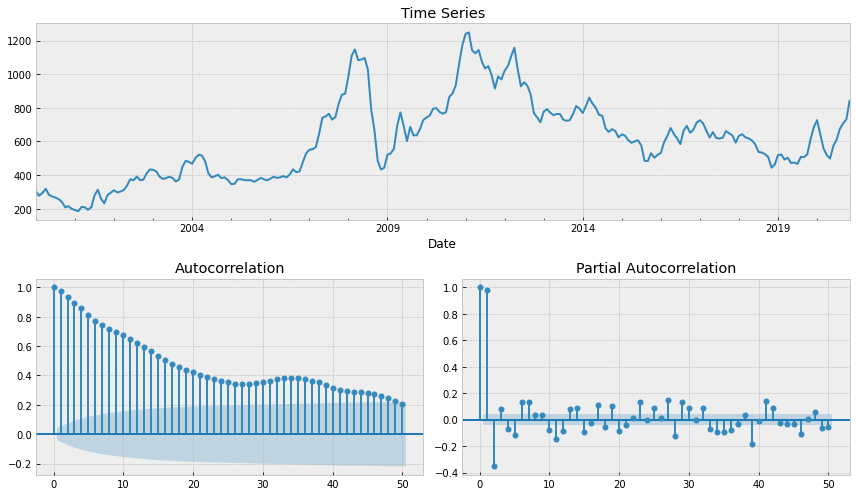

In [179]:
tsplot(data['Value'], lags=50)

Поскольку тест подтвердил, что ряд является не стационарным, т.е. его основные характеристики и свойства со временем - меняются (например, мат.ожидание на различных участках), то делать предсказания для таких рядов - бесполезное занятие. График автокорреляции явно показывает, что на поведение временного ряда оказывает сильное влияние тренд и цикличность.

Сюжет графика частичной автокорреляции показывает, что явной сезонной цикличности - нет.

Попробуем повысить стационарность временного ряда.

Построим ряд, значения которого будут состоять из разности значений исходного ряда со значениями ряда, смещенного относительно текущего на некоторый период (period). Зададим смещение на один период

In [180]:
data['PLM_diff'] = data['Value'].diff(periods=1)

In [181]:
data.head()

,Value,PLM_diff
Date,,
2000-01-31,301.789568,NaN
2000-02-29,277.579809,-24.209759
2000-03-31,294.389031,16.809222
2000-04-30,318.140906,23.751875
2000-05-31,283.167092,-34.973814


In [182]:
# Удалим строки с пустыми значениями
data = data.dropna(axis=0)

In [183]:
data.head()

,Value,PLM_diff
Date,,
2000-02-29,277.579809,-24.209759
2000-03-31,294.389031,16.809222
2000-04-30,318.140906,23.751875
2000-05-31,283.167092,-34.973814
2000-06-30,272.233919,-10.933173


Критерий Дики-Фуллера: p=0.000000


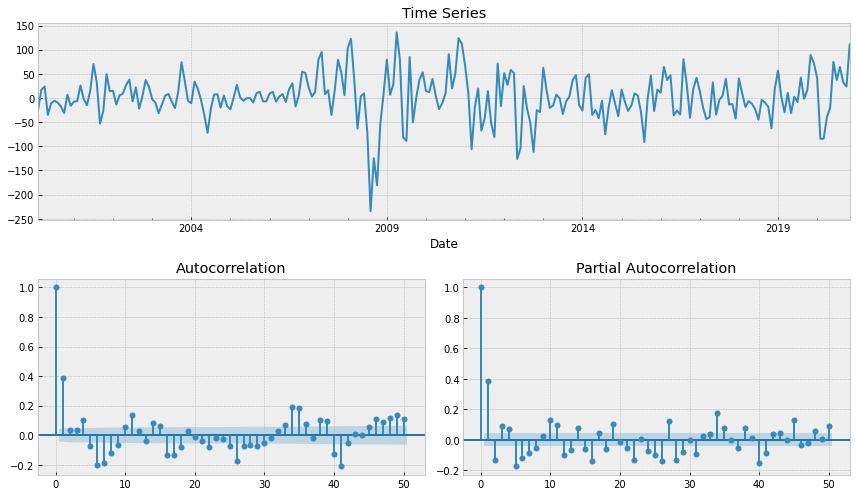

In [184]:
tsplot(data['PLM_diff'], lags=50)

Критерий Дики-Фуллера стремится к нулю; автокорелляции ряда - показывают колебания около нуля, ряд стационарен.

## Прогноз (SARIMA)

Для прогнозирования рядов с сезонным компонентом используется модель SARIMA. Настройка SARIMA требует выбора гиперпараметров как для трендовых, так и для сезонных элементов ряда. Первые три параметра, аналогичны параметрам более простой модели ARIMA.

Модель ARIMA содержит три параметра:

-   p: порядок компоненты AR
-   d: порядок интегрированного ряда (этот параметр знаем, т.к. смещение ряда = 1)
-   q: порядок компонетны MA

Есть четыре сезонных элемента, которые не являются частью ARIMA, которые должны быть настроены:

-   P: Сезонный порядок авторегрессии
-   D: Порядок сезонных разниц
-   Q: Сезонный порядок скользящих средних
-   m: Количество временных шагов за один сезонный период. m = 12 - для месячных данных (годовой сезонный цикл)

SARIMA(p,d,q)(P,D,Q)m

In [130]:
ps = range(0, 5)
d=1
qs = range(0, 4)
Ps = range(0, 5)
D=1
Qs = range(0, 1)

from itertools import product

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
print(f'Необходимо перебрать {len(parameters_list)} параметров модели')

Необходимо перебрать 100 параметров модели


In [235]:
results = []
best_aic = float("inf")

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        # наблюдаемый процесс (ряд - серия), внешние регрессоры
        model=sm.tsa.statespace.SARIMAX(data['PLM_diff'].dropna(axis=0), 
                                        order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)
                                        ).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

warnings.filterwarnings("ignore")

result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters          aic
58  (2, 3, 3, 0)  2524.320456
88  (4, 1, 3, 0)  2525.422303
59  (2, 3, 4, 0)  2525.857241
89  (4, 1, 4, 0)  2526.214130
13  (0, 2, 3, 0)  2527.869774


In [185]:
# Зададим параметры для модели SARIMA
best_model_plm_rbd = sm.tsa.statespace.SARIMAX(data['Value'].dropna(axis=0), 
                                               order=(2, d, 3),
                                               seasonal_order=(3, D, 0, 12)
                                               ).fit(disp=-1)
print(best_model_plm_rbd.summary())
warnings.filterwarnings("ignore")

                                      SARIMAX Results                                      
Dep. Variable:                               Value   No. Observations:                  250
Model:             SARIMAX(2, 1, 3)x(3, 1, [], 12)   Log Likelihood               -1245.501
Date:                             Tue, 09 Feb 2021   AIC                           2509.001
Time:                                     14:25:04   BIC                           2540.214
Sample:                                 02-29-2000   HQIC                          2521.582
                                      - 11-30-2020                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6305      0.042    -14.888      0.000      -0.713      -0.547
ar.L2         -0.8885      

Критерий Дики-Фуллера: p=0.000000


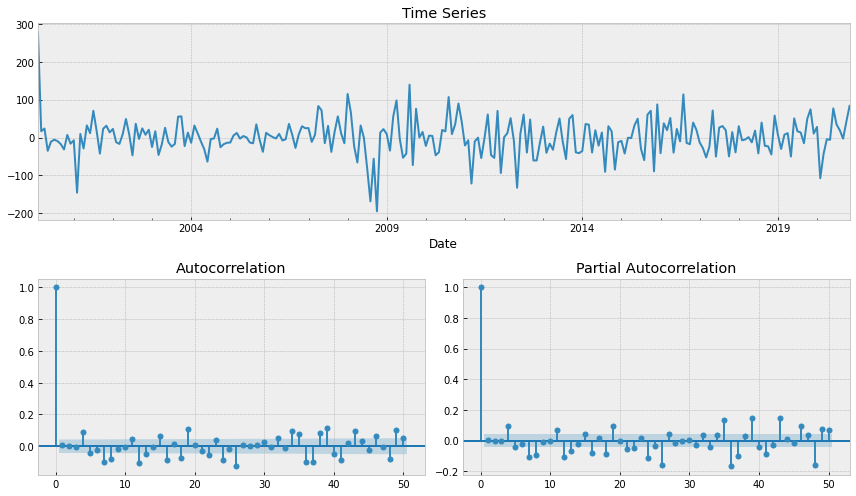

In [186]:
tsplot(best_model_plm_rbd.resid[:], lags=50)

In [187]:
data['Arima_plm_rbd'] = best_model_plm_rbd.fittedvalues

In [188]:
data.head()

,Value,PLM_diff,Arima_plm_rbd
Date,,,
2000-02-29,277.579809,-24.209759,0.000000
2000-03-31,294.389031,16.809222,277.778697
2000-04-30,318.140906,23.751875,294.382298
2000-05-31,283.167092,-34.973814,318.157859
2000-06-30,272.233919,-10.933173,283.144937


In [189]:
# Сделаем прогноз на основе обученной модели
forecast = best_model_plm_rbd.predict(start = data.shape[0], 
                                      end = data.shape[0]+12)
forecast = data['Arima_plm_rbd'].append(forecast).values[-(data.shape[0] + 12):]
actual = data['Value'].values[-(data.shape[0]):]

In [190]:
print(
    'Размерность исходного ряда', data.shape[0], '\n'
    'Размерность прогноза', forecast.shape
    )

Размерность исходного ряда 250 
Размерность прогноза (262,)


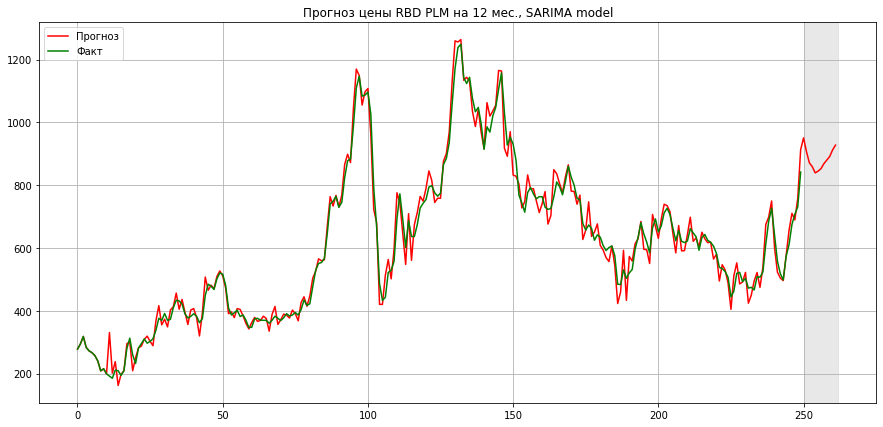

In [191]:
# Визуализируем полученные данные
plt.figure(figsize=(15, 7))
plt.plot(forecast, color='r', label="Прогноз")
plt.title('Прогноз цены RBD PLM на 12 мес., SARIMA model')
plt.plot(actual, color='g', label="Факт")
plt.legend()
plt.axvspan(len(actual), len(forecast), alpha=0.5, color='lightgrey')
plt.grid(True)

##  Метрики оценки модели

Для оценки качества работы модели будем судить по метрикам:

-   MAE - средняя абс. ошибка между таргетом и фактическим значением (ошибка интуитивно понятна, наглядна)
-   MAPE - MAE в %%

Для начала, подготовим датасет

In [192]:
# Столбец индексов - в столбец данных (даты)
data.reset_index(inplace=True)

In [193]:
data.head()

,Date,Value,PLM_diff,Arima_plm_rbd
0,2000-02-29,277.579809,-24.209759,0.000000
1,2000-03-31,294.389031,16.809222,277.778697
2,2000-04-30,318.140906,23.751875,294.382298
3,2000-05-31,283.167092,-34.973814,318.157859
4,2000-06-30,272.233919,-10.933173,283.144937


In [194]:
# Приведем к единому временному ряду прогноз и факт
result = pd.DataFrame()

current_values = data['Value'].values[-(data.shape[0]):]
zero_values = np.array([0 for i in range(12)])
actual_price = np.hstack((current_values, zero_values))
periods_num = forecast.shape[0]

result['Dt'] = pd.date_range(data['Date'][0], periods=periods_num, freq='M')
result['ActualPrice'] = actual_price
result['Forecast'] = forecast

In [196]:
result.tail()

,Dt,ActualPrice,Forecast
257,2021-07-31,0.0,868.379884
258,2021-08-31,0.0,879.557273
259,2021-09-30,0.0,891.214031
260,2021-10-31,0.0,912.223288
261,2021-11-30,0.0,927.417725


In [206]:
# Оценим ошибки модели
y_true = result['ActualPrice'].values[:-12]
y_pred = result['Forecast'].values[:-12]

mae = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred) * 100

print('MAE:', mae, 'MAPE:', mape)

MAE: 24.70106574842243 MAPE: 4.416856473760395


## Сохранение результатов в БД

In [232]:
def insert_into_db( data: pd.DataFrame, mae: float, mape: float,
                    dt_today: str ):
    """Вставляет переданные в функцию данные в БД"""

    # Авторизация в базе данных
    conn = psql.connect(
        dbname=auth.psql_db,
        user=auth.psql_user,
        password=auth.psql_passwd,
        host=auth.psql_host
    )

    cursor = conn.cursor()
    print('Создано подключение к БД:', auth.psql_db)
    print('Выполнение запроса...')

    for index, row in data.iterrows():
        values = (
            dt_today,
            f"{row['Dt']}", 
            row['ActualPrice'], 
            row['Forecast'],
            mae,
            mape
        )

        cursor.execute(
            """
            INSERT INTO 
            palmoilprice ( DtForecast, DtPeriod, ActualPrice, 
                           Forecast, MAE, MAPE ) 
            VALUES (%s, %s, %s, %s, %s, %s)
            """, values
        )

    print('Применение изменений...')
    conn.commit()

    cursor.close()
    print('Подключение к БД завершено')

    conn.close()
    print('Соединение с БД закрыто')

In [233]:
# Период отчета
today = datetime.datetime.today().date()
dt_today = f"{today.year}-{today.month}-{today.day}"
print(dt_today)

2021-2-9


In [234]:
# Сохраним данные в базу
insert_into_db(
    result,     # Таблица с прогнозом
    mae,        # Абс. ошибка
    mape,       # Отн. ошибка
    dt_today    # Дата (сегодня)
)

Создано подключение к БД: etl
Выполнение запроса...


Применение изменений...
Подключение к БД завершено
Соединение с БД закрыто
